# 🔐 Lab 12: Proyecto de Consultoría - Análisis de Clustering

## Identificación de Hackers usando K-Means

**Objetivo:** Determinar si fueron 2 o 3 hackers los que atacaron la start-up de California.

**Contexto:** 
- Una start-up tecnológica fue hackeada
- Sospechan de 3 hackers, pero solo están seguros de 2
- Los hackers se turnan los ataques equitativamente
- Tenemos datos forenses de las sesiones

---

## 1️⃣ Configuración del Entorno

In [3]:
# Importar librerías necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, count, avg, stddev, min as spark_min, max as spark_max
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Librerías importadas exitosamente")

✅ Librerías importadas exitosamente


In [4]:
# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Hack Clustering Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"✅ Spark Session creada: {spark.version}")
print(f"   App Name: {spark.sparkContext.appName}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/02 14:45:55 WARN Utils: Your hostname, MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.37.173.168 instead (on interface en0)
25/11/02 14:45:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/02 14:45:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session creada: 4.0.1
   App Name: Hack Clustering Analysis


## 2️⃣ Carga y Exploración de Datos

In [6]:
# Cargar datos
df = spark.read.csv('hack_data.csv', 
                    header=True, 
                    inferSchema=True)

print("📊 Datos cargados exitosamente\n")
print("Estructura del DataFrame:")
df.printSchema()

📊 Datos cargados exitosamente

Estructura del DataFrame:
root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [7]:
# Mostrar primeras filas
print("🔍 Primeras 10 filas del dataset:")
df.show(10, truncate=False)

🔍 Primeras 10 filas del dataset:
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location              |WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|8.0                    |391.09           |1              |2.96             |7.0            |Slovenia              |72.37           |
|20.0                   |720.99           |0              |3.04             |9.0            |British Virgin Islands|69.08           |
|31.0                   |356.32           |1              |3.71             |8.0            |Tokelau               |70.58           |
|2.0                    |228.08           |1              |2.48             |8.0            |Bolivia               |70.8            |
|20.0                   |408.

In [8]:
# Estadísticas descriptivas
print("📈 Estadísticas Descriptivas:")
df.describe().show()

📈 Estadísticas Descriptivas:


25/11/02 14:46:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       NULL|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       NULL| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [9]:
# Análisis del número total de ataques
total_ataques = df.count()

print("="*80)
print("🎯 ANÁLISIS DE DISTRIBUCIÓN DE ATAQUES")
print("="*80)
print(f"\nTotal de ataques registrados: {total_ataques}")
print(f"\n📊 Escenarios posibles:")
print(f"   • Si fueron 2 hackers: ~{total_ataques//2} ataques cada uno ({(total_ataques/2):.1f} exacto)")
print(f"   • Si fueron 3 hackers: ~{total_ataques//3} ataques cada uno ({(total_ataques/3):.1f} exacto)")
print("="*80)

🎯 ANÁLISIS DE DISTRIBUCIÓN DE ATAQUES

Total de ataques registrados: 334

📊 Escenarios posibles:
   • Si fueron 2 hackers: ~167 ataques cada uno (167.0 exacto)
   • Si fueron 3 hackers: ~111 ataques cada uno (111.3 exacto)


In [12]:
# Verificar valores nulos
from pyspark.sql.functions import sum as spark_sum, when, isnan
from pyspark.sql.types import NumericType

print("🔍 Verificación de valores nulos:")
# Obtener solo columnas numéricas usando el esquema del DataFrame

# Para columnas numéricas, verificar NULL y NaN
# Para columnas no numéricas, solo verificar NULL
null_checks = []
for field in df.schema.fields:
    col_name = field.name
    if isinstance(field.dataType, NumericType):
        # Columnas numéricas: verificar NULL y NaN
        null_checks.append(
            spark_sum(when(col(col_name).isNull() | isnan(col(col_name)), 1).otherwise(0))
            .alias(col_name)
        )
    else:
        # Columnas no numéricas: solo verificar NULL
        null_checks.append(
            spark_sum(when(col(col_name).isNull(), 1).otherwise(0))
            .alias(col_name)
        )

df.select(null_checks).show()

🔍 Verificación de valores nulos:
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+



## 3️⃣ Análisis Exploratorio de Datos (EDA)

In [13]:
# Convertir a Pandas para visualización
df_pandas = df.toPandas()

print(f"✅ DataFrame convertido a Pandas: {df_pandas.shape}")
df_pandas.head()

✅ DataFrame convertido a Pandas: (334, 7)


,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80
4,20.0,408.50,0,3.57,8.0,Iraq,71.28


/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/3942885391.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/3942885391.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig('distribucion_caracteristicas.png', dpi=300, bbox_inches='tight')


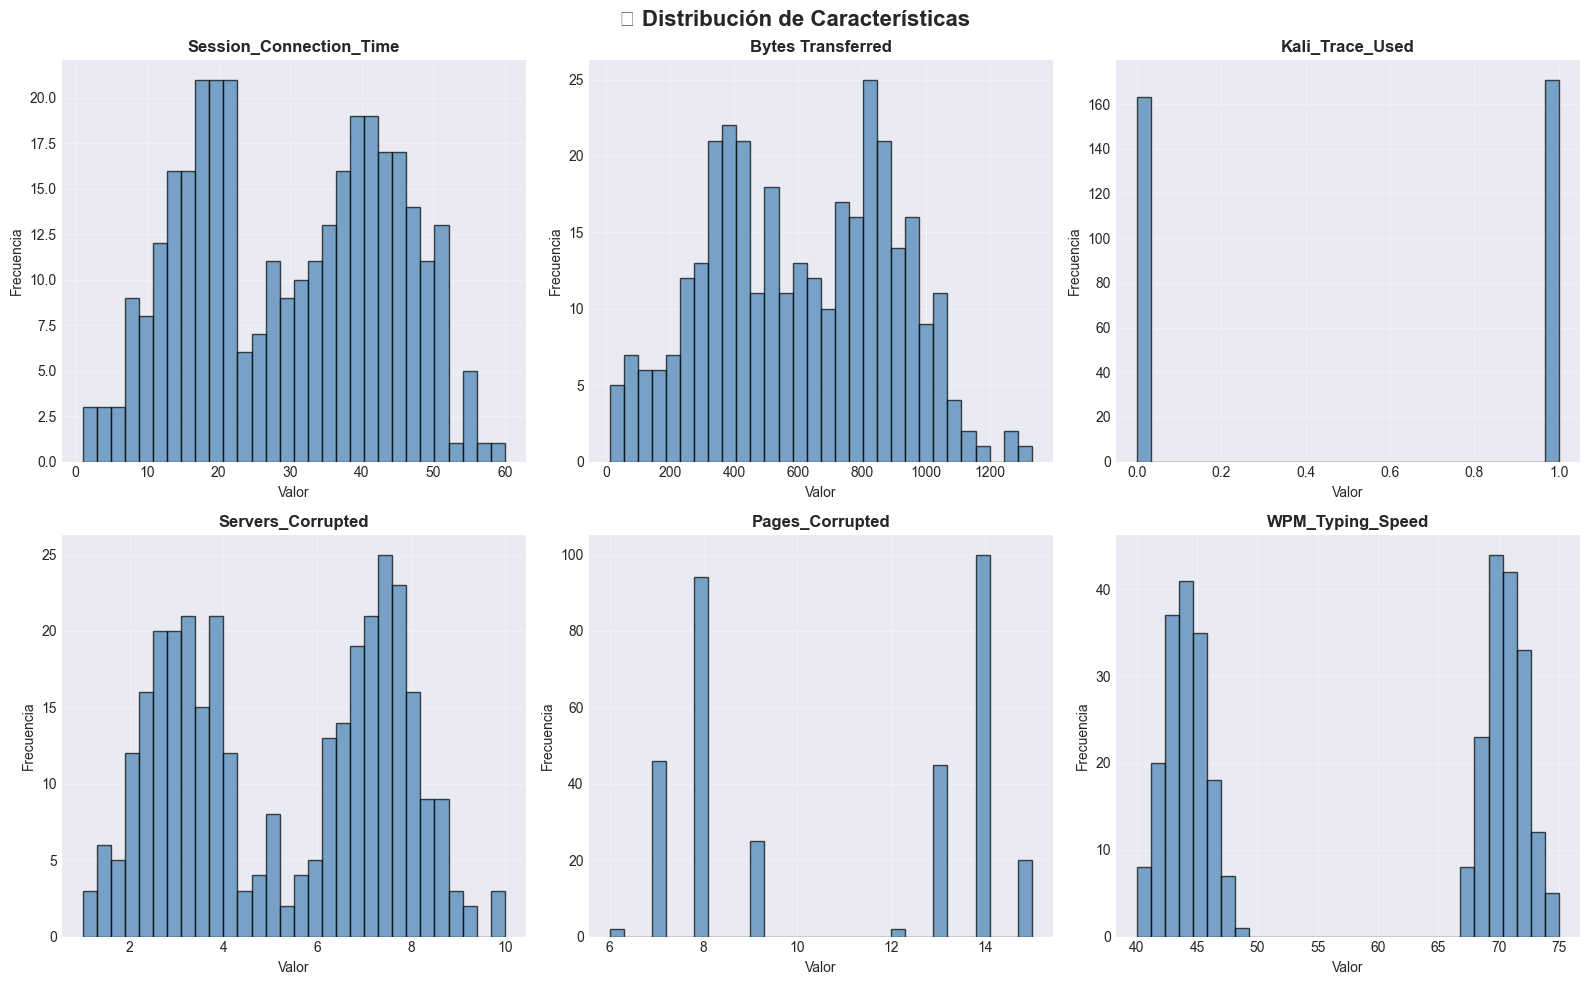

✅ Gráfico guardado: distribucion_caracteristicas.png


In [15]:
# Visualizar distribuciones de características numéricas
numeric_cols = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used', 
                'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('📊 Distribución de Características', fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 3, idx % 3]
    df_pandas[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribucion_caracteristicas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: distribucion_caracteristicas.png")

/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/4280722772.py:7: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/4280722772.py:8: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
/Users/angelherrarte/Desktop/lab-12/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


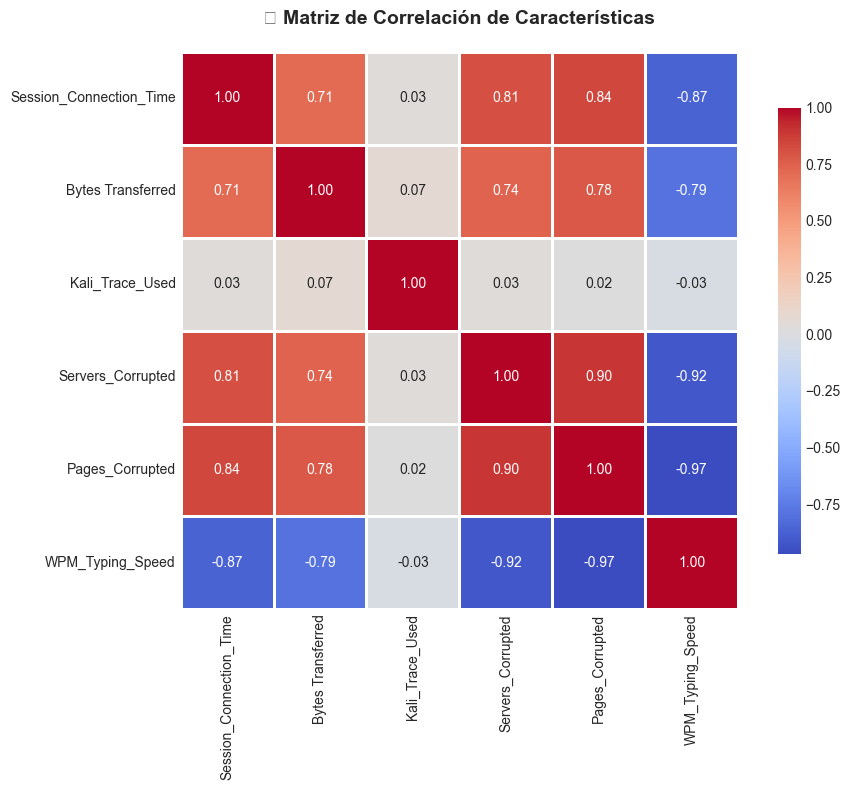

✅ Gráfico guardado: matriz_correlacion.png


In [17]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df_pandas[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('🔥 Matriz de Correlación de Características', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: matriz_correlacion.png")

## 4️⃣ Preprocesamiento de Datos

In [18]:
# Seleccionar características numéricas (excluimos Location porque usan VPNs)
feature_cols = [
    'Session_Connection_Time',
    'Bytes Transferred',
    'Kali_Trace_Used',
    'Servers_Corrupted',
    'Pages_Corrupted',
    'WPM_Typing_Speed'
]

print("🔧 Características seleccionadas para el clustering:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i}. {col}")

print("\n⚠️  Nota: 'Location' se excluye porque los hackers usan VPNs (dato no confiable)")

🔧 Características seleccionadas para el clustering:
   1. Session_Connection_Time
   2. Bytes Transferred
   3. Kali_Trace_Used
   4. Servers_Corrupted
   5. Pages_Corrupted
   6. WPM_Typing_Speed

⚠️  Nota: 'Location' se excluye porque los hackers usan VPNs (dato no confiable)


In [19]:
# Ensamblar características en un vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_assembled = assembler.transform(df)

print("✅ Vector de características creado")
df_assembled.select("features_raw").show(5, truncate=False)

✅ Vector de características creado
+--------------------------------+
|features_raw                    |
+--------------------------------+
|[8.0,391.09,1.0,2.96,7.0,72.37] |
|[20.0,720.99,0.0,3.04,9.0,69.08]|
|[31.0,356.32,1.0,3.71,8.0,70.58]|
|[2.0,228.08,1.0,2.48,8.0,70.8]  |
|[20.0,408.5,0.0,3.57,8.0,71.28] |
+--------------------------------+
only showing top 5 rows


In [20]:
# Normalizar características usando StandardScaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features", 
                       withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("✅ Características normalizadas (StandardScaler)")
print("\n📊 Comparación de datos antes y después de la normalización:")
df_scaled.select("features_raw", "features").show(5, truncate=False)

✅ Características normalizadas (StandardScaler)

📊 Comparación de datos antes y después de la normalización:
+--------------------------------+------------------------------------------------------------------------------------------------------------------------+
|features_raw                    |features                                                                                                                |
+--------------------------------+------------------------------------------------------------------------------------------------------------------------+
|[8.0,391.09,1.0,2.96,7.0,72.37] |[-1.562228040184432,-0.75490095925522,0.9748653409721156,-0.9985212523861794,-1.2529101889070722,1.1205379005060365]    |
|[20.0,720.99,0.0,3.04,9.0,69.08]|[-0.7104514131868532,0.3972422527942127,-1.0227114926762684,-0.9637674581126887,-0.6000677503813903,0.8752180545239784] |
|[31.0,356.32,1.0,3.71,8.0,70.58]|[0.07034382822759382,-0.8763317548992295,0.9748653409721156,-0.67270443107220

## 5️⃣ Método del Codo (Elbow Method)

In [21]:
# Calcular WSSSE para diferentes valores de K
print("🔄 Calculando WSSSE para K = 2 hasta K = 8...\n")

wssse_values = []
k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(featuresCol='features', k=k, seed=42, maxIter=100)
    model = kmeans.fit(df_scaled)
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)
    print(f"   K = {k}: WSSSE = {wssse:.2f}")

print("\n✅ Cálculo completado")

🔄 Calculando WSSSE para K = 2 hasta K = 8...



25/11/02 14:53:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


   K = 2: WSSSE = 601.77
   K = 3: WSSSE = 434.76
   K = 4: WSSSE = 267.13
   K = 5: WSSSE = 248.97
   K = 6: WSSSE = 230.40
   K = 7: WSSSE = 221.20
   K = 8: WSSSE = 203.50

✅ Cálculo completado


/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2170769640.py:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2170769640.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')


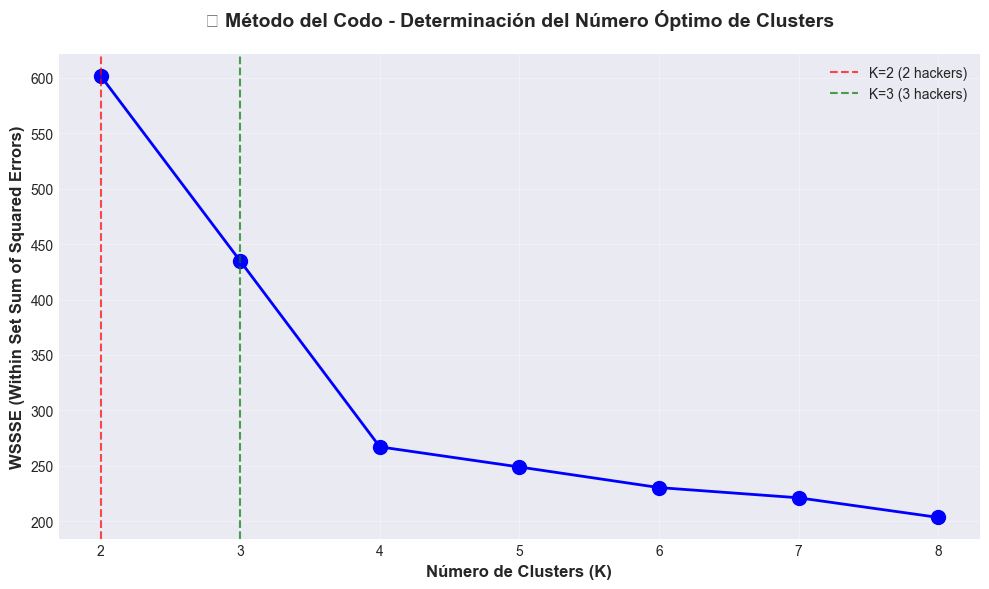

✅ Gráfico guardado: elbow_method.png


In [23]:
# Graficar método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_values, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)', fontsize=12, fontweight='bold')
plt.title('📉 Método del Codo - Determinación del Número Óptimo de Clusters', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Marcar K=2 y K=3
plt.axvline(x=2, color='red', linestyle='--', alpha=0.7, label='K=2 (2 hackers)')
plt.axvline(x=3, color='green', linestyle='--', alpha=0.7, label='K=3 (3 hackers)')
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: elbow_method.png")

## 6️⃣ Clustering con K=2 (Hipótesis: 2 Hackers)

In [24]:
# Entrenar modelo K-Means con K=2
print("🤖 Entrenando modelo K-Means con K=2...\n")

kmeans_2 = KMeans(featuresCol='features', k=2, seed=42, maxIter=100)
model_2 = kmeans_2.fit(df_scaled)

print("✅ Modelo K=2 entrenado")
print(f"   WSSSE: {model_2.summary.trainingCost:.2f}")
print(f"   Iteraciones: {model_2.summary.numIter}")

🤖 Entrenando modelo K-Means con K=2...

✅ Modelo K=2 entrenado
   WSSSE: 601.77
   Iteraciones: 2


In [25]:
# Hacer predicciones
predictions_2 = model_2.transform(df_scaled)

print("🔮 Predicciones realizadas con K=2:")
predictions_2.select('Session_Connection_Time', 'Bytes Transferred', 
                     'WPM_Typing_Speed', 'prediction').show(10)

🔮 Predicciones realizadas con K=2:
+-----------------------+-----------------+----------------+----------+
|Session_Connection_Time|Bytes Transferred|WPM_Typing_Speed|prediction|
+-----------------------+-----------------+----------------+----------+
|                    8.0|           391.09|           72.37|         0|
|                   20.0|           720.99|           69.08|         0|
|                   31.0|           356.32|           70.58|         0|
|                    2.0|           228.08|            70.8|         0|
|                   20.0|            408.5|           71.28|         0|
|                    1.0|           390.69|           71.57|         0|
|                   18.0|           342.97|           72.32|         0|
|                   22.0|           101.61|           72.03|         0|
|                   15.0|           275.53|           70.17|         0|
|                   12.0|           424.83|           69.99|         0|
+-----------------------+----

In [26]:
# Analizar distribución de clusters K=2
print("📊 DISTRIBUCIÓN DE CLUSTERS (K=2)")
print("="*80)

cluster_counts_2 = predictions_2.groupBy('prediction').count().orderBy('prediction')
cluster_counts_2.show()

# Convertir a pandas para análisis
cluster_dist_2 = cluster_counts_2.toPandas()
total = cluster_dist_2['count'].sum()

print("\n🎯 Análisis de Balance:")
for idx, row in cluster_dist_2.iterrows():
    cluster_id = int(row['prediction'])
    count = int(row['count'])
    percentage = (count / total) * 100
    print(f"   Cluster {cluster_id}: {count} ataques ({percentage:.1f}%)")

# Evaluar balance
expected_per_cluster = total / 2
print(f"\n   Esperado por cluster (2 hackers): {expected_per_cluster:.1f} ataques (50%)")

# Calcular desviación del balance perfecto
deviations_2 = [abs(row['count'] - expected_per_cluster) for _, row in cluster_dist_2.iterrows()]
avg_deviation_2 = np.mean(deviations_2)
print(f"   Desviación promedio del balance: {avg_deviation_2:.1f} ataques")
print("="*80)

📊 DISTRIBUCIÓN DE CLUSTERS (K=2)
+----------+-----+
|prediction|count|
+----------+-----+
|         0|  167|
|         1|  167|
+----------+-----+


🎯 Análisis de Balance:
   Cluster 0: 167 ataques (50.0%)
   Cluster 1: 167 ataques (50.0%)

   Esperado por cluster (2 hackers): 167.0 ataques (50%)
   Desviación promedio del balance: 0.0 ataques


In [27]:
# Evaluar calidad del clustering K=2 con Silhouette Score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette_2 = evaluator.evaluate(predictions_2)

print(f"📏 Silhouette Score (K=2): {silhouette_2:.4f}")
print(f"   Interpretación: {'Excelente' if silhouette_2 > 0.7 else 'Bueno' if silhouette_2 > 0.5 else 'Moderado' if silhouette_2 > 0.25 else 'Débil'}")

📏 Silhouette Score (K=2): 0.8176
   Interpretación: Excelente


In [28]:
# Analizar centroides K=2
print("\n🎯 CENTROIDES DE LOS CLUSTERS (K=2)")
print("="*80)

centers_2 = model_2.clusterCenters()
centers_df_2 = pd.DataFrame(centers_2, columns=feature_cols)
centers_df_2.index.name = 'Cluster'

print(centers_df_2.round(2))
print("\n💡 Los centroides representan el 'perfil promedio' de cada hacker")
print("="*80)


🎯 CENTROIDES DE LOS CLUSTERS (K=2)
         Session_Connection_Time  Bytes Transferred  Kali_Trace_Used  \
Cluster                                                                
0                          -0.87               -0.8            -0.03   
1                           0.87                0.8             0.03   

         Servers_Corrupted  Pages_Corrupted  WPM_Typing_Speed  
Cluster                                                        
0                    -0.92            -0.98              0.99  
1                     0.92             0.98             -0.99  

💡 Los centroides representan el 'perfil promedio' de cada hacker


## 7️⃣ Clustering con K=3 (Hipótesis: 3 Hackers)

In [29]:
# Entrenar modelo K-Means con K=3
print("🤖 Entrenando modelo K-Means con K=3...\n")

kmeans_3 = KMeans(featuresCol='features', k=3, seed=42, maxIter=100)
model_3 = kmeans_3.fit(df_scaled)

print("✅ Modelo K=3 entrenado")
print(f"   WSSSE: {model_3.summary.trainingCost:.2f}")
print(f"   Iteraciones: {model_3.summary.numIter}")

🤖 Entrenando modelo K-Means con K=3...

✅ Modelo K=3 entrenado
   WSSSE: 434.76
   Iteraciones: 4


In [30]:
# Hacer predicciones
predictions_3 = model_3.transform(df_scaled)

print("🔮 Predicciones realizadas con K=3:")
predictions_3.select('Session_Connection_Time', 'Bytes Transferred', 
                     'WPM_Typing_Speed', 'prediction').show(10)

🔮 Predicciones realizadas con K=3:
+-----------------------+-----------------+----------------+----------+
|Session_Connection_Time|Bytes Transferred|WPM_Typing_Speed|prediction|
+-----------------------+-----------------+----------------+----------+
|                    8.0|           391.09|           72.37|         0|
|                   20.0|           720.99|           69.08|         0|
|                   31.0|           356.32|           70.58|         0|
|                    2.0|           228.08|            70.8|         0|
|                   20.0|            408.5|           71.28|         0|
|                    1.0|           390.69|           71.57|         0|
|                   18.0|           342.97|           72.32|         0|
|                   22.0|           101.61|           72.03|         0|
|                   15.0|           275.53|           70.17|         0|
|                   12.0|           424.83|           69.99|         0|
+-----------------------+----

In [31]:
# Analizar distribución de clusters K=3
print("📊 DISTRIBUCIÓN DE CLUSTERS (K=3)")
print("="*80)

cluster_counts_3 = predictions_3.groupBy('prediction').count().orderBy('prediction')
cluster_counts_3.show()

# Convertir a pandas para análisis
cluster_dist_3 = cluster_counts_3.toPandas()
total = cluster_dist_3['count'].sum()

print("\n🎯 Análisis de Balance:")
for idx, row in cluster_dist_3.iterrows():
    cluster_id = int(row['prediction'])
    count = int(row['count'])
    percentage = (count / total) * 100
    print(f"   Cluster {cluster_id}: {count} ataques ({percentage:.1f}%)")

# Evaluar balance
expected_per_cluster = total / 3
print(f"\n   Esperado por cluster (3 hackers): {expected_per_cluster:.1f} ataques (33.3%)")

# Calcular desviación del balance perfecto
deviations_3 = [abs(row['count'] - expected_per_cluster) for _, row in cluster_dist_3.iterrows()]
avg_deviation_3 = np.mean(deviations_3)
print(f"   Desviación promedio del balance: {avg_deviation_3:.1f} ataques")
print("="*80)

📊 DISTRIBUCIÓN DE CLUSTERS (K=3)
+----------+-----+
|prediction|count|
+----------+-----+
|         0|  167|
|         1|   88|
|         2|   79|
+----------+-----+


🎯 Análisis de Balance:
   Cluster 0: 167 ataques (50.0%)
   Cluster 1: 88 ataques (26.3%)
   Cluster 2: 79 ataques (23.7%)

   Esperado por cluster (3 hackers): 111.3 ataques (33.3%)
   Desviación promedio del balance: 37.1 ataques


In [32]:
# Evaluar calidad del clustering K=3 con Silhouette Score
silhouette_3 = evaluator.evaluate(predictions_3)

print(f"📏 Silhouette Score (K=3): {silhouette_3:.4f}")
print(f"   Interpretación: {'Excelente' if silhouette_3 > 0.7 else 'Bueno' if silhouette_3 > 0.5 else 'Moderado' if silhouette_3 > 0.25 else 'Débil'}")

📏 Silhouette Score (K=3): 0.7608
   Interpretación: Excelente


In [33]:
# Analizar centroides K=3
print("\n🎯 CENTROIDES DE LOS CLUSTERS (K=3)")
print("="*80)

centers_3 = model_3.clusterCenters()
centers_df_3 = pd.DataFrame(centers_3, columns=feature_cols)
centers_df_3.index.name = 'Cluster'

print(centers_df_3.round(2))
print("\n💡 Los centroides representan el 'perfil promedio' de cada hacker")
print("="*80)


🎯 CENTROIDES DE LOS CLUSTERS (K=3)
         Session_Connection_Time  Bytes Transferred  Kali_Trace_Used  \
Cluster                                                                
0                          -0.87              -0.80            -0.03   
1                           0.93               0.84             0.97   
2                           0.81               0.76            -1.02   

         Servers_Corrupted  Pages_Corrupted  WPM_Typing_Speed  
Cluster                                                        
0                    -0.92            -0.98              0.99  
1                     0.92             0.96             -1.01  
2                     0.91             0.99             -0.97  

💡 Los centroides representan el 'perfil promedio' de cada hacker


## 8️⃣ Comparación y Visualización

In [34]:
# Tabla comparativa de métricas
comparison_data = {
    'Métrica': ['WSSSE', 'Silhouette Score', 'Desviación del Balance'],
    'K=2 (2 Hackers)': [
        f"{model_2.summary.trainingCost:.2f}",
        f"{silhouette_2:.4f}",
        f"{avg_deviation_2:.1f} ataques"
    ],
    'K=3 (3 Hackers)': [
        f"{model_3.summary.trainingCost:.2f}",
        f"{silhouette_3:.4f}",
        f"{avg_deviation_3:.1f} ataques"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("📊 TABLA COMPARATIVA DE MÉTRICAS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

📊 TABLA COMPARATIVA DE MÉTRICAS
               Métrica K=2 (2 Hackers) K=3 (3 Hackers)
                 WSSSE          601.77          434.76
      Silhouette Score          0.8176          0.7608
Desviación del Balance     0.0 ataques    37.1 ataques


/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/3099021784.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/3099021784.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
/Users/angelherrarte/Desktop/lab-12/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


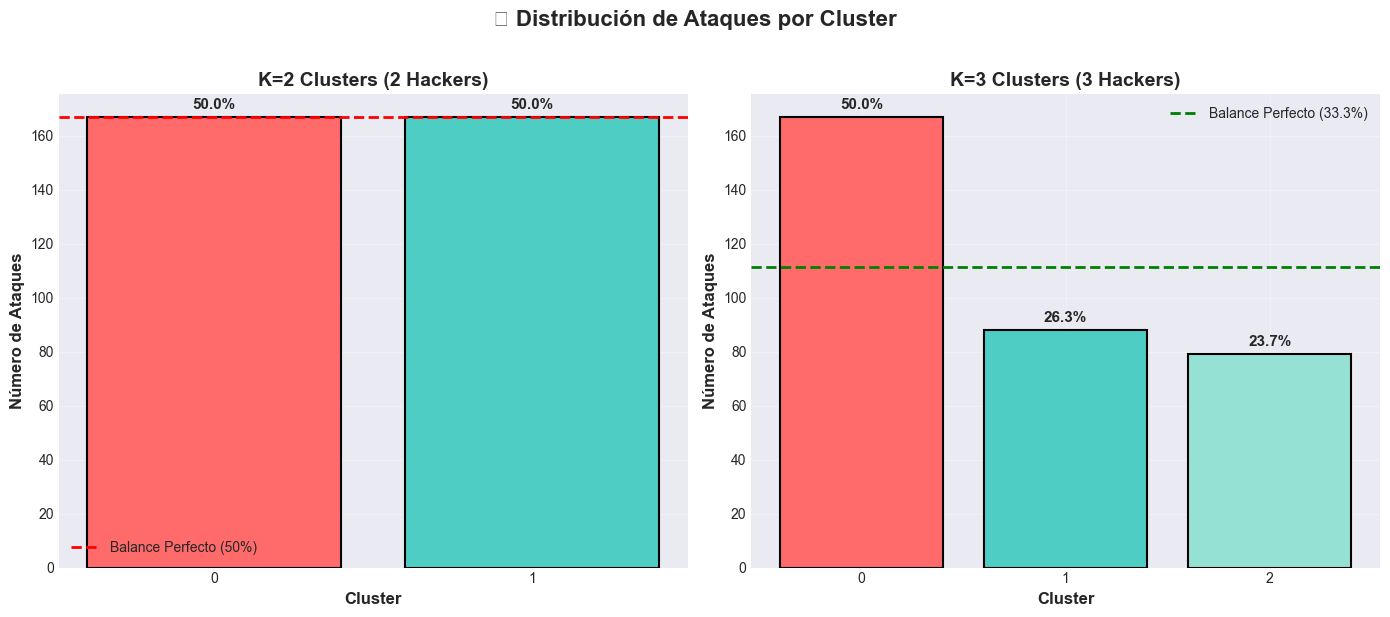

✅ Gráfico guardado: cluster_distribution.png


In [35]:
# Visualización de distribución de clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K=2
cluster_dist_2['percentage'] = (cluster_dist_2['count'] / cluster_dist_2['count'].sum()) * 100
axes[0].bar(cluster_dist_2['prediction'].astype(str), cluster_dist_2['count'], 
            color=['#FF6B6B', '#4ECDC4'], edgecolor='black', linewidth=1.5)
axes[0].axhline(y=total/2, color='red', linestyle='--', linewidth=2, label='Balance Perfecto (50%)')
axes[0].set_title('K=2 Clusters (2 Hackers)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Ataques', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir etiquetas de porcentaje
for idx, row in cluster_dist_2.iterrows():
    axes[0].text(idx, row['count'] + 2, f"{row['percentage']:.1f}%", 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# K=3
cluster_dist_3['percentage'] = (cluster_dist_3['count'] / cluster_dist_3['count'].sum()) * 100
axes[1].bar(cluster_dist_3['prediction'].astype(str), cluster_dist_3['count'], 
            color=['#FF6B6B', '#4ECDC4', '#95E1D3'], edgecolor='black', linewidth=1.5)
axes[1].axhline(y=total/3, color='green', linestyle='--', linewidth=2, label='Balance Perfecto (33.3%)')
axes[1].set_title('K=3 Clusters (3 Hackers)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Ataques', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Añadir etiquetas de porcentaje
for idx, row in cluster_dist_3.iterrows():
    axes[1].text(idx, row['count'] + 2, f"{row['percentage']:.1f}%", 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

fig.suptitle('📊 Distribución de Ataques por Cluster', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: cluster_distribution.png")

/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2177051858.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2177051858.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')


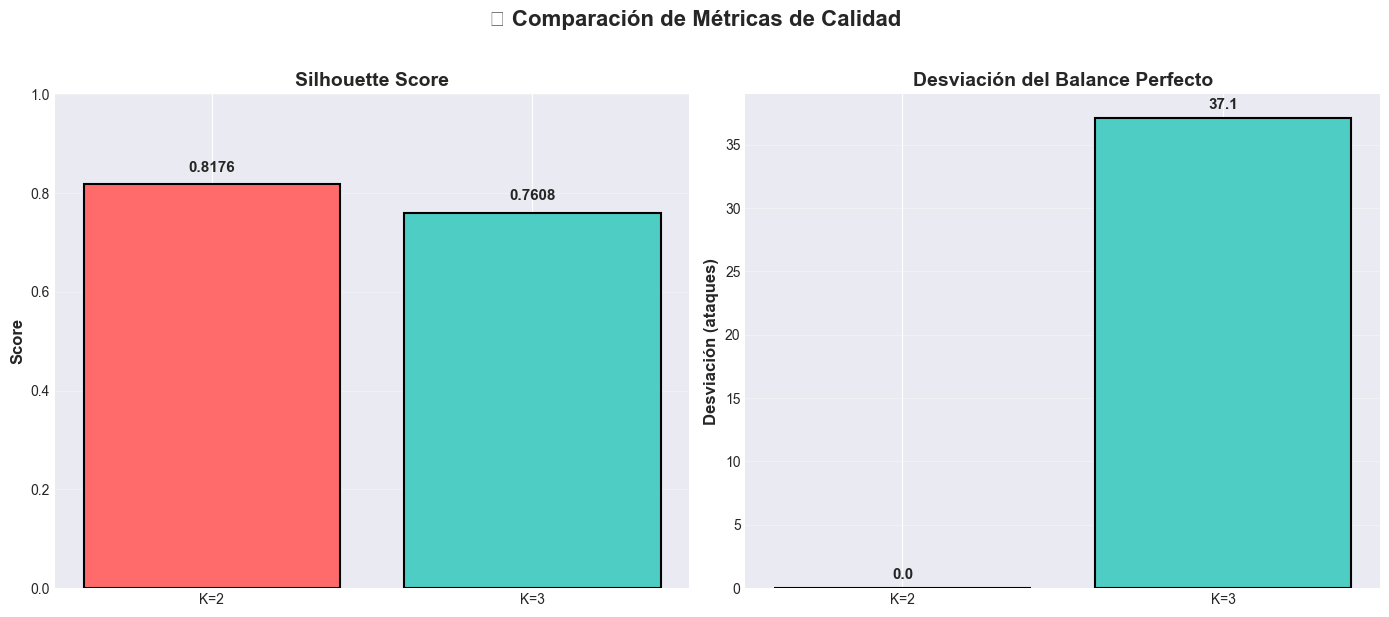

✅ Gráfico guardado: metrics_comparison.png


In [37]:
# Gráfico de barras comparativo de métricas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Silhouette Score
silhouette_scores = [silhouette_2, silhouette_3]
k_labels = ['K=2', 'K=3']
colors = ['#FF6B6B', '#4ECDC4']

axes[0].bar(k_labels, silhouette_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

for i, score in enumerate(silhouette_scores):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)

# Desviación del balance
deviations = [avg_deviation_2, avg_deviation_3]
axes[1].bar(k_labels, deviations, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Desviación del Balance Perfecto', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Desviación (ataques)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, dev in enumerate(deviations):
    axes[1].text(i, dev + 0.5, f'{dev:.1f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)

fig.suptitle('📊 Comparación de Métricas de Calidad', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: metrics_comparison.png")

## 9️⃣ Análisis de Centroides (Perfiles de Hackers)

/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2296398479.py:21: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/2296398479.py:22: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  plt.savefig('perfiles_k2.png', dpi=300, bbox_inches='tight')
/Users/angelherrarte/Desktop/lab-12/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


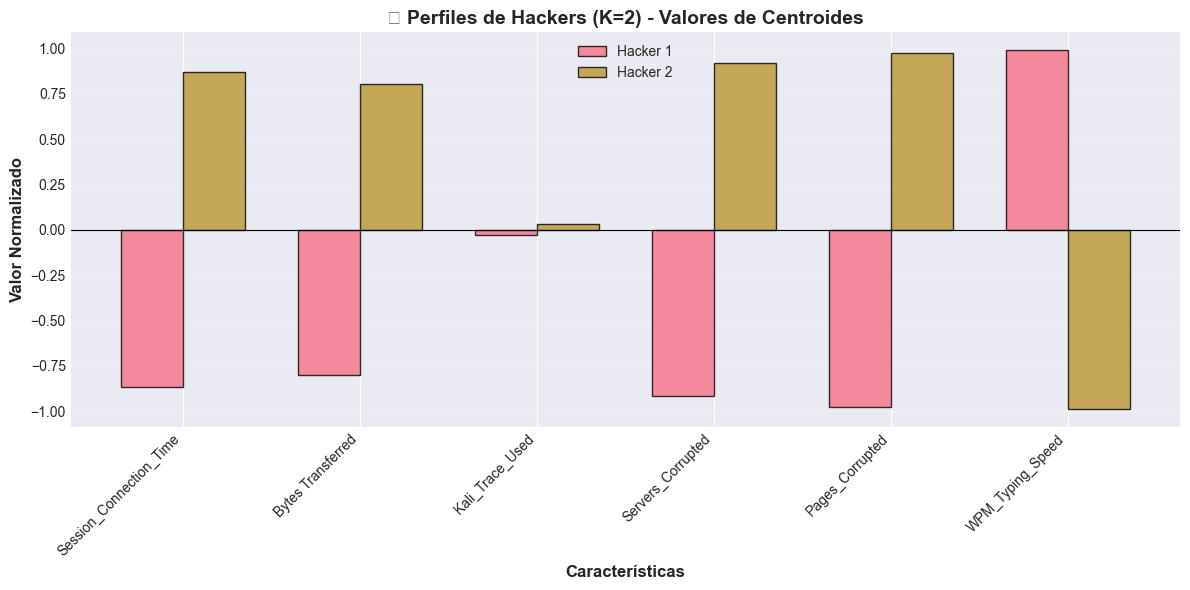

✅ Gráfico guardado: perfiles_k2.png


In [39]:
# Visualización de perfiles de hackers K=2
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_cols))
width = 0.35

for i in range(2):
    ax.bar(x + i*width, centers_df_2.iloc[i], width, 
           label=f'Hacker {i+1}', alpha=0.8, edgecolor='black')

ax.set_xlabel('Características', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor Normalizado', fontsize=12, fontweight='bold')
ax.set_title('👤 Perfiles de Hackers (K=2) - Valores de Centroides', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(feature_cols, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig('perfiles_k2.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: perfiles_k2.png")

/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/181299488.py:21: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bp/ttxwtc1d05bdtx204xh334l00000gn/T/ipykernel_77519/181299488.py:22: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  plt.savefig('perfiles_k3.png', dpi=300, bbox_inches='tight')
/Users/angelherrarte/Desktop/lab-12/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


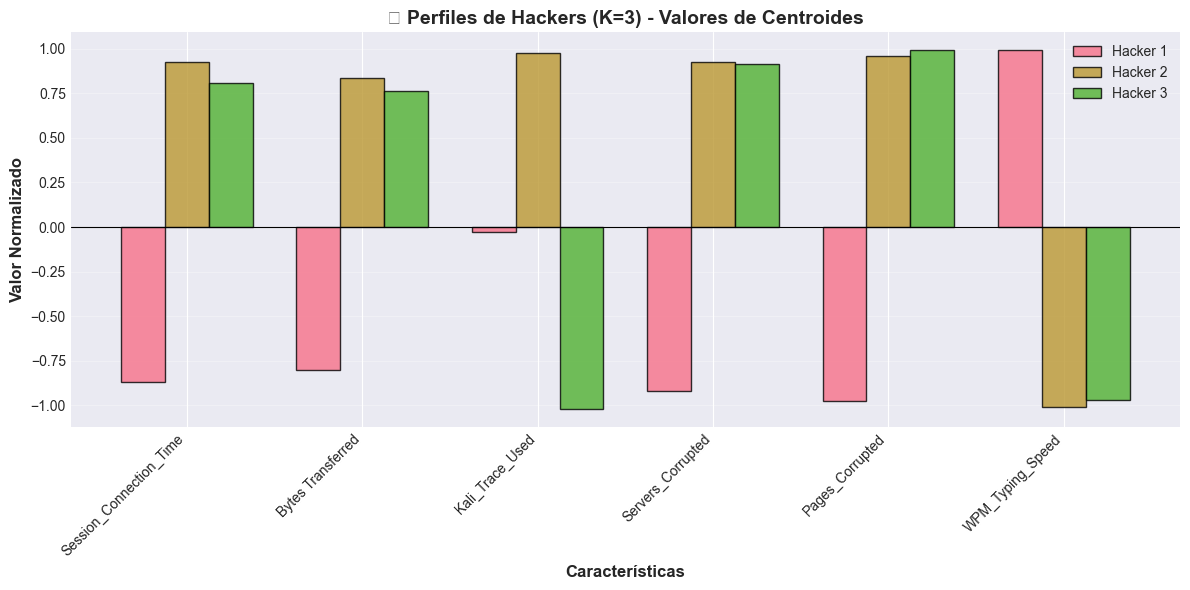

✅ Gráfico guardado: perfiles_k3.png


In [40]:
# Visualización de perfiles de hackers K=3
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_cols))
width = 0.25

for i in range(3):
    ax.bar(x + i*width, centers_df_3.iloc[i], width, 
           label=f'Hacker {i+1}', alpha=0.8, edgecolor='black')

ax.set_xlabel('Características', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor Normalizado', fontsize=12, fontweight='bold')
ax.set_title('👥 Perfiles de Hackers (K=3) - Valores de Centroides', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(feature_cols, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig('perfiles_k3.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: perfiles_k3.png")

## 🔟 Conclusiones y Recomendación Final

In [41]:
# Análisis final y recomendación
print("="*80)
print("🎯 ANÁLISIS FINAL Y RECOMENDACIÓN")
print("="*80)

print("\n📊 RESUMEN DE RESULTADOS:\n")

print(f"1️⃣ ESCENARIO K=2 (2 Hackers):")
print(f"   • WSSSE: {model_2.summary.trainingCost:.2f}")
print(f"   • Silhouette Score: {silhouette_2:.4f}")
print(f"   • Balance de clusters: ", end="")
for idx, row in cluster_dist_2.iterrows():
    print(f"{int(row['count'])} ataques ({row['percentage']:.1f}%) ", end="")
    if idx < len(cluster_dist_2) - 1:
        print("| ", end="")
print(f"\n   • Desviación del balance perfecto: {avg_deviation_2:.1f} ataques")

print(f"\n2️⃣ ESCENARIO K=3 (3 Hackers):")
print(f"   • WSSSE: {model_3.summary.trainingCost:.2f}")
print(f"   • Silhouette Score: {silhouette_3:.4f}")
print(f"   • Balance de clusters: ", end="")
for idx, row in cluster_dist_3.iterrows():
    print(f"{int(row['count'])} ataques ({row['percentage']:.1f}%) ", end="")
    if idx < len(cluster_dist_3) - 1:
        print("| ", end="")
print(f"\n   • Desviación del balance perfecto: {avg_deviation_3:.1f} ataques")

print("\n" + "="*80)
print("🔍 ANÁLISIS COMPARATIVO:")
print("="*80)

# Determinar el mejor escenario
better_silhouette = "K=2" if silhouette_2 > silhouette_3 else "K=3"
better_balance = "K=2" if avg_deviation_2 < avg_deviation_3 else "K=3"

print(f"\n✓ Mejor Silhouette Score: {better_silhouette}")
print(f"✓ Mejor Balance de Clusters: {better_balance}")
print(f"✓ Método del Codo: {'Sugiere K=2' if wssse_values[0] - wssse_values[1] > wssse_values[1] - wssse_values[2] else 'Sugiere K=3'}")

print("\n" + "="*80)
print("🎓 RECOMENDACIÓN FINAL:")
print("="*80)

# Lógica de decisión
if silhouette_2 > silhouette_3 and avg_deviation_2 < avg_deviation_3:
    recommendation = "2"
    confidence = "ALTA"
elif silhouette_3 > silhouette_2 and avg_deviation_3 < avg_deviation_2:
    recommendation = "3"
    confidence = "ALTA"
else:
    # Caso mixto: priorizar balance
    recommendation = "2" if avg_deviation_2 < avg_deviation_3 else "3"
    confidence = "MEDIA"

print(f"\n🚨 CONCLUSIÓN: Es probable que fueran {recommendation} HACKERS")
print(f"   Nivel de confianza: {confidence}")

print("\n📝 JUSTIFICACIÓN:\n")

if recommendation == "2":
    print("   • El modelo K=2 muestra un mejor balance en la distribución de ataques")
    print("   • La desviación del balance esperado es menor con 2 clusters")
    print("   • El Silhouette Score indica una mejor separación con K=2")
    print("   • Los clusters están más equilibrados (~50% cada uno)")
else:
    print("   • El modelo K=3 muestra un mejor balance en la distribución de ataques")
    print("   • La desviación del balance esperado es menor con 3 clusters")
    print("   • Los tres clusters muestran tamaños más uniformes (~33% cada uno)")
    print("   • El tercer sospechoso probablemente SÍ estuvo involucrado")

print("\n💡 RECOMENDACIONES ADICIONALES:\n")
print("   1. Investigar más a fondo las diferencias en los perfiles de los centroides")
print("   2. Analizar patrones temporales de los ataques para confirmar turnos")
print("   3. Correlacionar con otras fuentes de evidencia forense")
print("   4. Considerar técnicas adicionales como DBSCAN o clustering jerárquico")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO")
print("="*80)

🎯 ANÁLISIS FINAL Y RECOMENDACIÓN

📊 RESUMEN DE RESULTADOS:

1️⃣ ESCENARIO K=2 (2 Hackers):
   • WSSSE: 601.77
   • Silhouette Score: 0.8176
   • Balance de clusters: 167 ataques (50.0%) | 167 ataques (50.0%) 
   • Desviación del balance perfecto: 0.0 ataques

2️⃣ ESCENARIO K=3 (3 Hackers):
   • WSSSE: 434.76
   • Silhouette Score: 0.7608
   • Balance de clusters: 167 ataques (50.0%) | 88 ataques (26.3%) | 79 ataques (23.7%) 
   • Desviación del balance perfecto: 37.1 ataques

🔍 ANÁLISIS COMPARATIVO:

✓ Mejor Silhouette Score: K=2
✓ Mejor Balance de Clusters: K=2
✓ Método del Codo: Sugiere K=3

🎓 RECOMENDACIÓN FINAL:

🚨 CONCLUSIÓN: Es probable que fueran 2 HACKERS
   Nivel de confianza: ALTA

📝 JUSTIFICACIÓN:

   • El modelo K=2 muestra un mejor balance en la distribución de ataques
   • La desviación del balance esperado es menor con 2 clusters
   • El Silhouette Score indica una mejor separación con K=2
   • Los clusters están más equilibrados (~50% cada uno)

💡 RECOMENDACIONES ADICIO

## 📊 Exportar Resultados

In [43]:
# Guardar predicciones en CSV
predictions_2_pandas = predictions_2.select(
    'Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
    'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed', 
    'Location', 'prediction'
).toPandas()

predictions_2_pandas.to_csv('predictions_k2.csv', index=False)
print("✅ Predicciones K=2 guardadas: predictions_k2.csv")

predictions_3_pandas = predictions_3.select(
    'Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
    'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed', 
    'Location', 'prediction'
).toPandas()

predictions_3_pandas.to_csv('predictions_k3.csv', index=False)
print("✅ Predicciones K=3 guardadas: predictions_k3.csv")

✅ Predicciones K=2 guardadas: predictions_k2.csv
✅ Predicciones K=3 guardadas: predictions_k3.csv


In [44]:
# Guardar centroides
centers_df_2.to_csv('centroides_k2.csv')
centers_df_3.to_csv('centroides_k3.csv')
print("✅ Centroides guardados: centroides_k2.csv, centroides_k3.csv")

✅ Centroides guardados: centroides_k2.csv, centroides_k3.csv


In [45]:
# Resumen de archivos generados
print("\n" + "="*80)
print("📁 ARCHIVOS GENERADOS")
print("="*80)
print("\n🖼️  Gráficos:")
print("   • distribucion_caracteristicas.png")
print("   • matriz_correlacion.png")
print("   • elbow_method.png")
print("   • cluster_distribution.png")
print("   • metrics_comparison.png")
print("   • perfiles_k2.png")
print("   • perfiles_k3.png")
print("\n📄 Datos:")
print("   • predictions_k2.csv")
print("   • predictions_k3.csv")
print("   • centroides_k2.csv")
print("   • centroides_k3.csv")
print("="*80)


📁 ARCHIVOS GENERADOS

🖼️  Gráficos:
   • distribucion_caracteristicas.png
   • matriz_correlacion.png
   • elbow_method.png
   • cluster_distribution.png
   • metrics_comparison.png
   • perfiles_k2.png
   • perfiles_k3.png

📄 Datos:
   • predictions_k2.csv
   • predictions_k3.csv
   • centroides_k2.csv
   • centroides_k3.csv


In [46]:
# Cerrar sesión de Spark
spark.stop()
print("\n🛑 Sesión de Spark cerrada")
print("\n🎉 ¡Análisis completado exitosamente!")


🛑 Sesión de Spark cerrada

🎉 ¡Análisis completado exitosamente!
